In [1]:
import jax
import jax.numpy as jnp
import sys
from jax import random

sys.path.append('/Users/dashiell/workspace/simplex-score-matching/src')

from ssm.simplex_proj import vector_simplex_proj
from ssm.visualize_simplex import rotate_simplex_to_xy


key = random.PRNGKey(42)

data = jnp.array([
    
    [79.07, 12.83, 8.10],
    [31.74, 56.69, 11.57],
    [18.61, 72.05, 9.34 ],
    [49.51, 15.11, 35.38],
    [29.22, 52.36, 18.42],
    [21.99, 59.91, 18.10],
    [11.74, 65.04, 23.22],
    [24.47, 52.53, 23.00],
    [5.14,  38.39, 56.47],
    [15.54, 57.34, 27.11],
    [57.17, 3.81,  39.02],
    [52.25, 23.73, 24.02],
    [77.40, 9.13,  13.47],
    [10.54, 20.34, 69.12],
    [46.14, 15.97, 37.89],
    [16.29, 69.18, 14.53],
    [32.27, 36.20, 31.53],
    [40.73, 47.41, 11.86],
    [49.29, 42.74,  7.97],
    [61.39, 7.63,  30.88]
 ])


/Users/dashiell/miniconda3/envs/ssm/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import chex

def perturb(a: chex.Array, b: chex.Array) -> chex.Array:
    """ Vector addition on the simplex with the Aitchison geometry
    """
    x = jnp.multiply(a, b)
    return x / jnp.sum(x)


def apow(a, alpha) -> chex.Array:
    """ Scalar multiplication on the simplex with the Aitchison geometry
    """
    x =  a ** alpha
    return x / jnp.sum(x)


@jax.jit
def _index_pairs(dim: int)-> chex.Array:
    return jnp.array(list(itertools.combinations(range(dim), 2)))


def circulant(x: chex.Array) -> chex.Array:
    """ Takes a vector (i.e. shape "(k,)") and returns the circulant k x k matrix
    # TODO: Can I use this to cleverly calculate the Aitchison inner product?
    """
    chex.assert_rank()
    size = x.size
    circ = jnp.concatenate(
        [jnp.roll(x, i)[None] for i in range(size)]
    )
    return circ.T


@jax.jit
def aitch_dot(a: chex.Array, b: chex.Array) -> chex.Scalar:
    """ Inner product between two elements of the simplex with the Aitchison geometry
    """
    d = a.size[-1]
    indices =  jnp.array(_index_pairs(d))
    def pairwise(val, pair):
        i, j = pair[0], pair[1]
        sum1 = jnp.log(a[i])/jnp.log(a[j]) * jnp.log(b[i])/jnp.log(b[j])
        sum2 = jnp.log(a[j])/jnp.log(a[i]) * jnp.log(b[j])/jnp.log(b[i])
        return val + sum1 + sum2
    return jax.lax.scan(pairwise, 0., indices)



def aitch_basis(dim: int):
    total = dim - 1. + jnp.e
    basis = jnp.ones((dim, dim))
    i = jnp.diag_indices(dim)
    return basis.at[i].set(jnp.e) / total




def clr(x: chex.Array) -> chex.Array:
    """ Centered log ration (clr) transform of a point on the simplex. Takes a point in the canonical basis to 
    """
    log_x = jnp.log(x)
    geom_mean = jnp.exp(jnp.mean(log_x))
    return jnp.log(x / geom_mean)

def clr_inv(x: chex.Array) -> chex.Array:
    """ The in
    """
    return jax.nn.softmax(x)


def ilr(x: chex.Array) -> chex.Array:
    """
    """
    pass



In [19]:
x0 = data[0]
x0

DeviceArray([79.07, 12.83,  8.1 ], dtype=float32)

In [21]:
log_x = jnp.log(x0)
log_x

DeviceArray([4.3703337, 2.5517862, 2.091864 ], dtype=float32)

In [22]:
geom_mean = jnp.exp(jnp.mean(log_x))
geom_mean

DeviceArray(20.179386, dtype=float32)

In [34]:
ab = aitch_basis(3)


In [40]:
coeffs = jnp.matmul(jax.vmap(clr)(ab), clr(data[0]/data[0].sum()))
x0 = apow(ab[0], coeffs[0])
x1 = apow(ab[1], coeffs[1])
x2 = apow(ab[2], coeffs[2])

In [41]:
print(x0)
print(x1)
print(x2)

[0.6620683  0.16896585 0.16896585]
[0.37939182 0.24121639 0.37939182]
[0.4164238  0.4164238  0.16715245]


In [42]:
perturb(perturb(x0, x1)

DeviceArray([0.79069996, 0.12830003, 0.08100001], dtype=float32)

In [287]:
import math
from functools import cache

@cache
def _vector(dim: int, i: int):
    x = jnp.zeros((dim,))
    x = x.at[0:i].set(1/i).at[i].set(-1)
    x *= jnp.sqrt(i / (i + 1))
    return x


@cache
def ortho_basis_rn(dim: int):
    vectors = [
        _vector(dim, i)[None] for i in range(1, dim)
    ]
    return jnp.concatenate(vectors)

@cache
def ortho_basis_simn(dim: int):
    return jax.vmap(clr_inv)(ortho_basis_rn(dim))
    
    
def ilr(x):
    """ x in Sim^D, this function sends it to R^(D-1) according to an orthonormal basis
    """
    d = x.shape[-1]
    ortho = ortho_basis_rn(d)
    return jnp.matmul(ortho, clr(x))
    
def ilr_inv(y):
    """ y in R^(D-1), this function sends it to Sim^D
    """
    d = y.shape[-1]
    basis = ortho_basis_simn(d + 1)
    vals = []
    for i in range(d):
        vals.append(apow(basis[i], y[i]))
    return jax.tree_util.tree_reduce(perturb, vals)


def ilr_inv2(y):
    d = y.shape[-1]
    basis = ortho_basis_rn(d + 1)
    return clr_inv(jnp.matmul(jnp.transpose(basis), y))
    
    
def riemann_inv_metric(x):
    """ The inverse metric tensor g^(-1) of the Riemannian metric on the simplex at point `x`. Also the Jacobian of the softmax at point `x`
    """
    d = x.shape[-1]
    
    def same_ind(i, j):
        return x[i] * (1. - x[i])

    def diff_ind(i, j):
        return -1. * x[i] * x[j]
    
    def _g(i):
        ks = jnp.arange(d)
        return jax.lax.map(
            lambda j: jax.lax.cond(i == j, same_ind, diff_ind, i, j),
            ks
        )
    return jax.lax.map(_g, jnp.arange(d))
    

In [288]:
ilr_inv2(ilr(jnp.array([.99, .005, .005])))

DeviceArray([0.98999995, 0.005     , 0.005     ], dtype=float32)

In [425]:

start = jnp.array([0.2, 0.4, 0.4])
key = jax.random.PRNGKey(52)
dt = 0.01
rand_increments = jax.random.normal(key, (1_000_000, 2))*jnp.sqrt(dt)
simp_increments = jax.vmap(ilr_inv2)(rand_increments)

def make_sde(alpha, gamma, dt):
    
    def _sde(xt, noise):
        g_inv = riemann_inv_metric(xt)
        rescaled_noise = clr_inv(jnp.matmul(g_inv, noise))
        x_ou = apow(
            perturb(gamma, apow(xt, -1.)),
            alpha * dt
        )
        new_loc = perturb(xt, perturb(x_ou, rescaled_noise))
        return new_loc, new_loc
    return _sde



In [447]:
start = jnp.array([.99, .005, .005])
sde = make_sde(0.01, jnp.array([1/3, 1/3, 1/3]), dt)
fin, path = jax.lax.scan(sde, start, simp_increments)

In [448]:
path

DeviceArray([[0.9899938 , 0.00500368, 0.00500243],
             [0.9899863 , 0.0050079 , 0.00500581],
             [0.9899768 , 0.00501157, 0.00501159],
             ...,
             [0.12802172, 0.1373855 , 0.7345928 ],
             [0.12844676, 0.13786805, 0.7336852 ],
             [0.12905017, 0.13799065, 0.7329593 ]], dtype=float32)

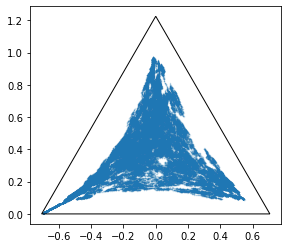

<Figure size 720x720 with 0 Axes>

In [461]:
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])

plt.figure()

X = jax.vmap(rotate_simplex_to_xy)(path)
plt.scatter(X[0:200000,0], X[0:200000,1], alpha=.2, s=.1)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.figure(figsize=(10,10))
plt.show()

In [455]:
key, subkey = random.split(key)

random.dirichlet(key, alpha=jnp.ones(3), shape=(10000,))
sq32 = np.sqrt(3/2)
sq22 = np.sqrt(2)/2
triangle = np.array([[0, sq32], [-sq22, 0], [sq22, 0]])

plt.figure()
#path = get_simplex_path(10_000, 2, key)
simp3_unif = random.dirichlet(key, alpha=jnp.ones(3), shape=(10000,))
X = batch_rotate(simp3_unif)
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.5)
t1 = plt.Polygon(triangle, fill=False)
plt.gca().add_patch(t1)
plt.gca().set_aspect('equal')
plt.show()

NameError: name 'batch_rotate' is not defined

<Figure size 432x288 with 0 Axes>

In [53]:
jnp.array([2, 3, 4, 5])**2

DeviceArray([ 4,  9, 16, 25], dtype=int32)

In [315]:
from jax import jacfwd, jacrev

sfm = jax.nn.softmax

jacfwd(jacrev(sfm))(jnp.array([1., 1., 1.]))

DeviceArray([[[ 0.07407409, -0.03703704, -0.03703704],
              [-0.03703704, -0.03703704,  0.07407407],
              [-0.03703704,  0.07407407, -0.03703704]],

             [[-0.03703704, -0.03703704,  0.07407407],
              [-0.03703704,  0.07407409, -0.03703704],
              [ 0.07407407, -0.03703704, -0.03703704]],

             [[-0.03703704,  0.07407407, -0.03703704],
              [ 0.07407407, -0.03703704, -0.03703704],
              [-0.03703704, -0.03703704,  0.07407409]]], dtype=float32)

In [371]:
riemann_inv_metric(jnp.array([1/3, 1/3, 1/3])).sum(1)

DeviceArray([-2.9802322e-08, -2.9802322e-08, -2.9802322e-08], dtype=float32)

In [333]:
x = jnp.array([2., 3., 4.])
i = 1
j = 2

def same_ind(i, j, x):
        return x[i] * (1. - x[i])

def diff_ind(i, j, x):
    return -1. * x[i] * x[j]
jax.lax.cond(i == j, same_ind, diff_ind, i, j, x)

DeviceArray(-12., dtype=float32)

In [79]:
dist = 1 - x1.sum()


tensor(0.8000)

In [80]:
z = torch.zeros((3,))

In [81]:
z

tensor([0., 0., 0.])

In [85]:
z.index_add_(0, torch.tensor([1, 2]), torch.tensor([2., 2.]))


tensor([0., 2., 2.])

In [90]:
z = torch.tensor([1., 2., 3., 4.])
torch.tile(z, (3, 1))

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]])

In [92]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [131]:
from torchtyping import TensorType

def cube_to_simplex_project(x: TensorType['batch', -1]):
    assert torch.all(x >= 0) and torch.all(x <= 1)
    lambda_0 = torch.mean(1 - x, dim=1)
    x_0 = 
    # black magic
    # more seriously, example, goes from tensor with shape (batch, dim) such as
    # the 3x2 tensor [[.19, .61], [.61, .65], [.8, .05]] to  (batch, dim, dim) 3x2x2
    # [[[0.1900, 0.6100],
    #   [0.1900, 0.6100]],
    #  [[0.6100, 0.6500],
    #   [0.6100, 0.6500]],
    #  [[0.8000, 0.0500],
    #   [0.8000, 0.0500]]]
    many_xs = torch.tile(x[:, None], (1, x.shape[1], 1))
    dist_diags = torch.cat([torch.eye(x.shape[-1])[None] * d for d in dist_to_simplex])
    return torch.mean(dist_diags + many_xs, dim=1)

In [123]:
torch.tile(x[:,None], (1, 2, 1))

tensor([[[0.1900, 0.6100],
         [0.1900, 0.6100]],

        [[0.6100, 0.6500],
         [0.6100, 0.6500]],

        [[0.8000, 0.0500],
         [0.8000, 0.0500]]])

In [119]:
torch.tile(x, (1, x.shape[-1]))

tensor([[0.1900, 0.6100, 0.1900, 0.6100],
        [0.6100, 0.6500, 0.6100, 0.6500],
        [0.8000, 0.0500, 0.8000, 0.0500]])

In [125]:
(1 - x.sum(1)).tolist()

[0.19999998807907104, -0.25999999046325684, 0.1499999761581421]

In [141]:
x = torch.rand((1, 3))
cube_to_simplex_project(x)

tensor([[-0.2162,  0.6114,  0.6048]])

In [142]:
x

tensor([[0.0474, 0.8751, 0.8684]])

In [143]:
d = 1 - torch.sum(x, 1)
d

tensor([-0.7909])